# Imports and midi loading

Now we have a trainable discriminator - it's time to build the environment

TODO:
    - discriminator into env
        - plot(copy from disc notebook): prediction of discriminator over time 
        - reverse postprocessing to set range for actions
        - train discriminator after trajectory
        - make it more efficient by making discriminator stateful and always feed a single time step
    - models => lstm
   

In [33]:
## Imports and data loading

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import metrics

from musicrl.midi2vec import MidiVectorMapper
from musicrl.render import *
from musicrl.data import RandomMidiDataGenerator

import pretty_midi
from glob import glob


import pprint
pprint = pprint.PrettyPrinter(indent=4).pprint


REAL = 1
GEN = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
filepaths = list(glob('maestro-v2.0.0/2008/**.midi'))
real_midis = [pretty_midi.PrettyMIDI(i) for i in filepaths]
mapper = MidiVectorMapper(real_midis)

In [35]:
mapper = MidiVectorMapper(real_midis)
real_seq = mapper.midi2vec(real_midis[1])
real_seq.shape

(60867, 5)

In [ ]:
real_seqs = [mapper.midi2vec(i) for i in real_midis]
shortest = np.min(np.array(list(map( lambda seq: len(seq), real_seqs))))
_real_seq=np.array(list(map(lambda seq: seq[0:shortest] ,real_seqs )))

# Load the discriminator

In [ ]:
discriminator = load_model("models/seq_lstm.h5")

In [ ]:
print(discriminator.inputs)
discriminator.summary()

In [ ]:
mapper.dims

# Environment

In [ ]:
import gym
import pretty_midi


class SeqEnvironment(gym.Env):
    """We ignore control change events for now
    """
    def __init__(
        self,
        discriminator,
        mapper,
        change_rate=0.01,
        batch_size=32
    ):
        super().__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        # self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        # Example for using image as input:
        # self.observation_space = spaces.Box(low=0, high=255,
        #                                    shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        self.discriminator = discriminator
        self.mapper = mapper
        self.observation_shape = [mapper.dims]
        self.change_rate = change_rate
        self.batch_size = batch_size
        self.reset()
        
    def step(self, actions):
        assert len(actions)==self.batch_size, f"Expected batch_size of {self.batch_size}"
        self.current_seqs.append(actions)
        bs = len(actions)
        self.observations  = self.observations \
            + np.random.normal(0, self.change_rate, size=[bs] + self.observation_shape)
        self.done = self.done | self.mapper.is_done(actions)
        
        reward = self.discriminator.predict(
            np.transpose(self.current_seqs, [1, 0, 2])
        )[:,-1,:]
        return np.array(self.observations), reward, self.done, None
    
    def reset(self):
        self.current_seqs = []
        self.done = np.array([False]*self.batch_size)
        self.observations = np.random.normal(0, 1, size=[self.batch_size] + self.observation_shape)
        return self.observations  # reward, done, info can't be included

    def render(self, mode='human'):
        pass
    
    def close (self):
        pass

In [71]:
discriminator.fit

<bound method Model.fit of <tensorflow.python.keras.engine.sequential.Sequential object at 0x14f41c9b0>>

# Training Loop

In [ ]:
from musicrl.agent import *
from musicrl.models import *
from tqdm import *
import pdb

batch_size = 4
agent = DDPG(mapper.dims,mapper.dims,act_range=3)
env = SeqEnvironment(discriminator, mapper, batch_size=batch_size)


# First, gather experience
config = {
    "nb_episodes" : 1
}

print(range(config["nb_episodes"]))

tqdm_e = tqdm(range(config["nb_episodes"]), desc='Score', leave=True, unit=" episodes")
for e in tqdm_e:

    # Reset episode
    cumul_reward, done = np.zeros((batch_size, 1)), 0
    old_state = env.reset()
    actions, states, rewards = [], [], []
    
    step = 0
    while not np.mean(done)>0.5:
        
        if step>10:
            break;
        print("Step", step)
        step += 1
        env.render()
        # Actor picks an action (following the deterministic policy)   
        
        actions = agent.policy_action(old_state)
        states, rewards, dones, _ = env.step(actions) #new_states -> bs of new_state
        q_values = agent.critic.target_model.predict([states, agent.actor.target_model.predict(states)])
        # Compute critic target

        critic_target = agent.bellman(rewards, q_values, dones)
    
        # Train both networks on sampled batch, update target networks
        agent.update_models(states, actions, critic_target)
        # Update current state
        cumul_reward += rewards
    postprocess_and_synthesize(np.array([seq[0] for seq in env.current_seqs]))
            
    train_discriminator(np.transpose(env.current_seqs, [1,0,2]),real_seqs,env.batch_size)


    # Display score
    tqdm_e.set_description("Score: " + str(cumul_reward))
    tqdm_e.refresh()
















Score:   0%|          | 0/1 [00:00<?, ? episodes/s]

range(0, 1)
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10


> <ipython-input-180-bbdf2d3bfaa8>(5)train_discriminator()
-> x = fake_seqs
(Pdb) l.
  1  	def train_discriminator(fake_seqs,real_seqs,batch_size):
  2  	    import pdb
  3  	    pdb.set_trace()
  4  	
  5  ->	    x = fake_seqs
  6  	    y=np.zeros(len(x))  #fake=0
  7  	
  8  	    x_real = gen_real_midis_batch(batch_size,real_seqs,x.shape[1])
  9  	    y_real = np.ones( (batch_size,1)  ) #real=1;
 10  	
 11  	    x = np.concatenate((x,x_real))
(Pdb) c
> <ipython-input-187-c8b14c297905>(5)gen_real_midis_batch()
-> return np.array(list(map( lambda midi: midi[0:nr_timestep], real_seqs[shuffled_indices][0:batch_size])))
(Pdb) l.
  1  	def gen_real_midis_batch(batch_size, real_seqs, nr_timestep):
  2  	    shuffled_indices=np.random.permutation(len(real_seqs))
  3  	    import pdb
  4  	    pdb.set_trace()
  5  ->	    return np.array(list(map( lambda midi: midi[0:nr_timestep], real_seqs[shuffled_indices][0:batch_size])))
  6  	
[EOF]
(Pdb) shuffled_indices.shape
(147,)
(Pdb) real_seqs[shuf

In [187]:
def gen_real_midis_batch(batch_size, real_seqs, nr_timestep):
    shuffled_indices=np.random.permutation(len(real_seqs))  
    import pdb
    pdb.set_trace()
    return np.array(list(map( lambda midi: midi[0:nr_timestep], real_seqs[shuffled_indices][0:batch_size])))
    

In [180]:
def train_discriminator(fake_seqs,real_seqs,batch_size):
    import pdb
    pdb.set_trace()
    
    x = fake_seqs
    y=np.zeros(len(x))  #fake=0
    
    x_real = gen_real_midis_batch(batch_size,real_seqs,x.shape[1])    
    y_real = np.ones( (batch_size,1)  ) #real=1;
    
    x = np.concatenate((x,x_real))
    y = np.concetenate( (y,y_real) )
        
    discriminator.fit(x,y)

In [17]:
np.array(env.current_seqs).shape

(132, 4, 5)

# Listen to it

In [40]:
from musicrl.midi2vec import PostProcessor

def postprocess_and_synthesize(gen_seq):
    postprocess = PostProcessor([mapper.midi2vec(real_midi) for real_midi in real_midis[:5]])
    gen_seq[:,0] += 0.4
    gen_seq = postprocess(gen_seq)
    gen_midi = mapper.vec2midi(gen_seq)
    listen_to(gen_midi)

In [45]:
current_seqs_list = np.array([seq[i] for seq in env.current_seqs])
for i in range(env.batch_size):
    postprocess_and_synthesize(current_seqs_list)

No handles with labels found to put in legend.


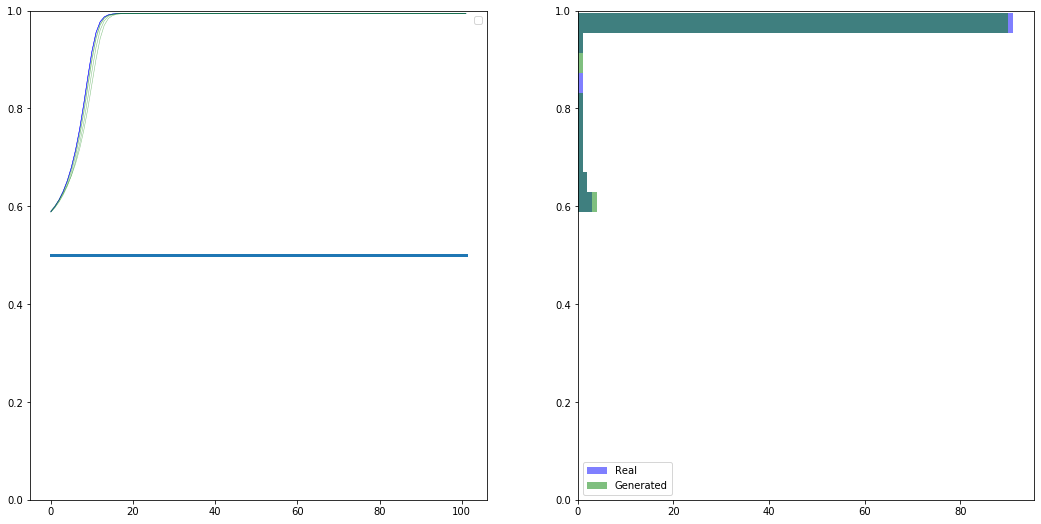

In [68]:
gen_seqs = np.array(env.current_seqs).transpose([1, 0, 2])
#reals = np.array([mapper.midi2vec(i) for i in real_midis])
plot_predictions_over_time(discriminator, np.zeros(gen_seqs.shape), gen_seqs)